In [1]:
!pip install camb

In [2]:
import camb
from tqdm import tqdm
from numpy import random
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

def define_plot_resolution():
    fig = plt.gcf()

    DPI = fig.get_dpi()
    fig.set_size_inches(12, 8)
    ax = plt.gca()
    for tickLabel in ax.get_xticklabels()+ax.get_yticklabels():
        tickLabel.set_fontsize(22)
    ax.yaxis.label.set_size(22)
    ax.xaxis.label.set_size(22)
    ax.yaxis.offsetText.set_fontsize(22)
    ax.xaxis.offsetText.set_fontsize(22)
    return

def Cl_th(As, ns, H0, ombh2, omch2, tau, lmax, mode = 1):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, tau=tau)
    pars.InitPower.set_params(As=As, ns=ns)
    results = camb.get_results(pars)
    cl = results.get_total_cls(lmax, CMB_unit='muK', raw_cl=True)*1e-12
    return cl.T[mode, 2:lmax+1]


#clth = np.load("ILC/clth_all.npy")
ombh2, omch2, H0, ns, As, tau_input  = 0.02237, 0.12, 67.36, 0.965, 2.099e-09, 0.0544
clth = Cl_th(As, ns, H0, ombh2, omch2, tau_input, 47)
Aseminus2tau = As*np.exp(-2*tau_input)
nside = 16
lmax = 3*nside-1
ell = np.arange(2, lmax+1, 1)


# Generate some noisy cls

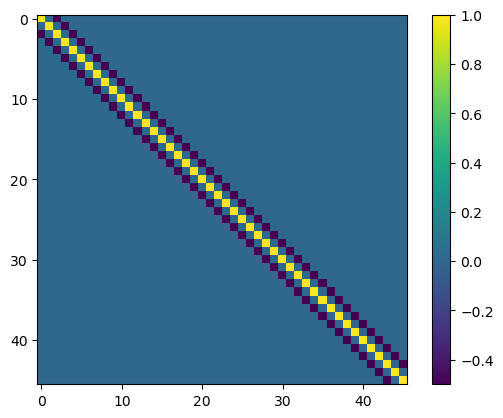

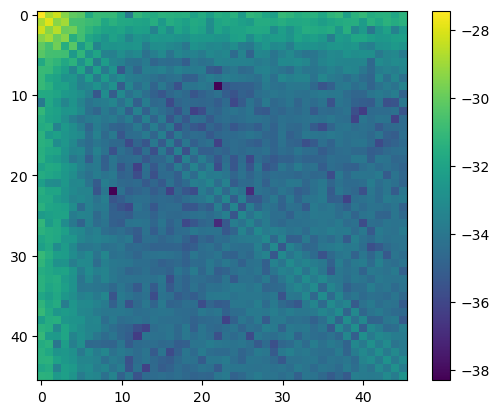

In [3]:
# start from a l*l' noise correlation matrix with 30 ell between 2 and 31
correlations = True # either with or without correlations
my_corr = np.identity(lmax-1)
if correlations:
    for i in range(lmax-1-2): 
        my_corr[i, i+2] = -0.5 # 0
        my_corr[i+2, i] = -0.5 # 0
plt.figure()
plt.imshow(my_corr)
plt.colorbar()
plt.show()


# Assume a white noise 1e-15 K on the diagonal
N = 1e-15
diag = N**2*np.ones((lmax-1))
# or a tilted noise...
diag = (5e-13*(ell)**-3.)**2
# or just the cosmic variance on the diagonal
diag = 2/(2*ell+1)*clth**2
# to get the true covariance
my_cov = np.einsum('i,ij,j->ij', np.sqrt(diag), my_corr, np.sqrt(diag)) # my_cov = N**2*my_corr

# build n cl that are clth + noise generated from this covariance
n = 100
cls = np.array(n*[clth[:lmax-1]])
corr_noise = random.multivariate_normal(len(my_cov)*[0],my_cov, size = (100))
cls = np.array(cls)+corr_noise


# empirical covariance of the cls looks like
plt.figure()
plt.imshow(np.log10(np.abs(np.cov(cls.T))))
plt.colorbar()
plt.show()

# Plot these

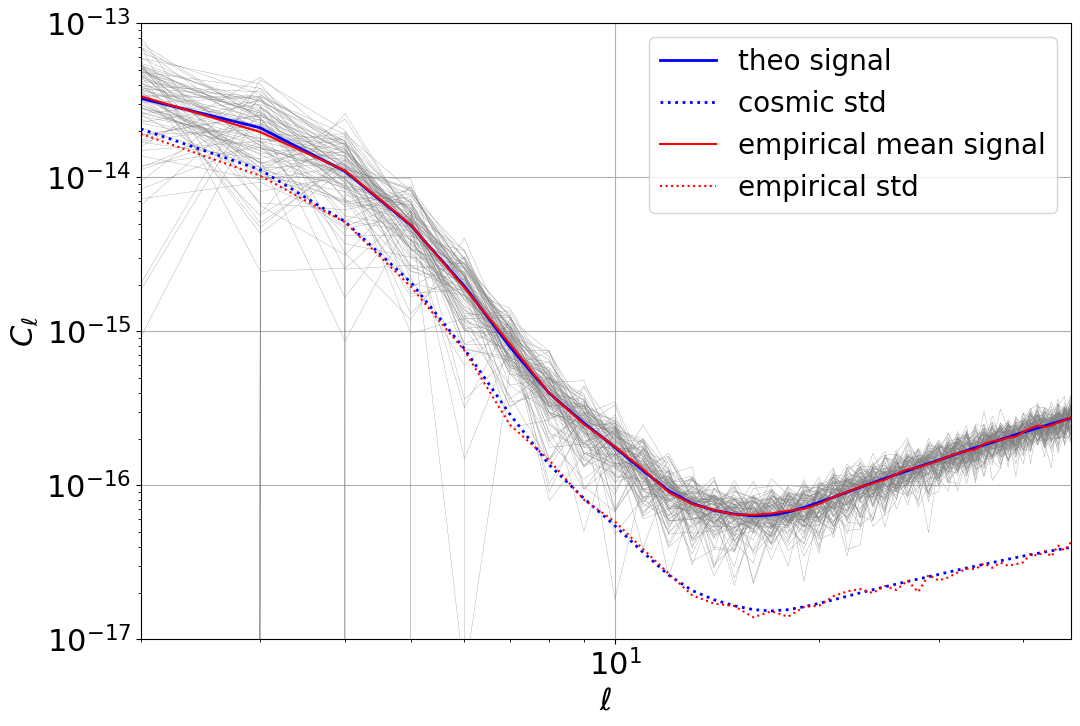

0.2% of them are negative


In [4]:
plt.figure(figsize = (10,8))
for i in range(n): plt.plot(ell, cls[i], color='gray', lw = 0.2)
plt.plot(ell, clth[:lmax-1], label = 'theo signal', lw = 2, color = 'blue', ls = '-')
plt.plot(ell, np.sqrt(2/(2*ell+1))*clth[:lmax-1], label = 'cosmic std', color = 'blue', lw = 2, ls = ':')

plt.plot(ell, np.mean(cls, axis = 0), label = 'empirical mean signal', ls = '-', color = 'red')
plt.plot(ell, np.std(cls, axis = 0), label = 'empirical std', ls = ':', color = 'red')

plt.loglog()
plt.grid()
plt.legend(fontsize = 20)
plt.xlim(2, lmax)
plt.ylim(1e-17, 1e-13)
plt.ylabel(r'$C_\ell$')
plt.xlabel(r'$\ell$')
define_plot_resolution()
plt.show()

print(str(round(np.sum(cls<0)/np.sum(cls>-1e3)*100, 1))+'% of them are negative')



# Verify that thare is no bias in these

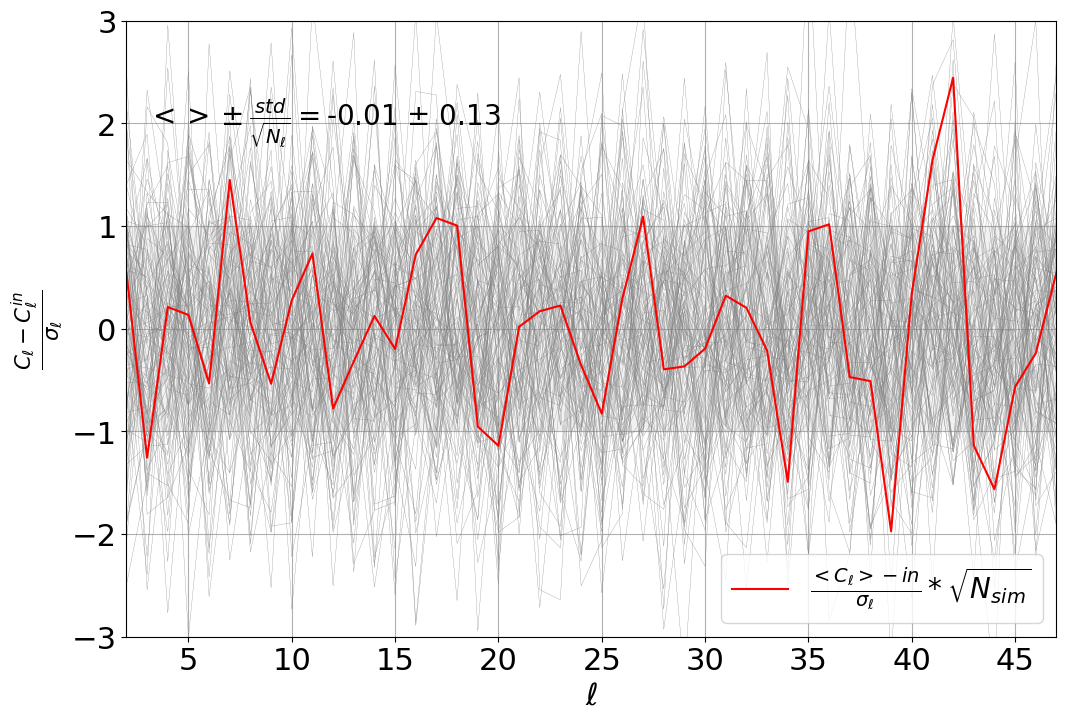

In [5]:
plt.figure(figsize = (10,8))
for i in range(n): plt.plot(ell, (cls[i]-clth[:lmax-1])/np.std(cls, axis = 0), color='gray', lw = 0.2)
plt.plot(ell, (np.mean(cls, axis = 0)-clth[:lmax-1])/np.std(cls, axis = 0)*np.sqrt(n), label = r'$\frac{<C_\ell>-in}{\sigma_\ell}*\sqrt{N_{sim}}$', ls = '-', color = 'red')
plt.axhspan(-1, 1, color = 'lightgray', alpha=0.3)
plt.legend(fontsize = 20)
plt.xlim(2, lmax)
plt.ylim(-3, 3)
plt.grid()

mean_bias = np.mean((np.mean(cls, axis = 0)-clth[:lmax-1])/np.std(cls, axis = 0)*np.sqrt(n))
err_bias = np.std((np.mean(cls, axis = 0)-clth[:lmax-1])/np.std(cls, axis = 0)*np.sqrt(n))/np.sqrt(len(cls[0,2:]))

plt.text(3, 1.5, s = ''+
         r'$<>\pm \frac{std}{\sqrt{N_{\ell}}}=$'+f'{round(mean_bias, 2)}'+r' $\pm$ '+ f'{round(err_bias,2)}'+'\n',
         fontsize = 20)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\frac{C_\ell-C_\ell^{in}}{\sigma_\ell}$')
define_plot_resolution()
plt.show()


# Determine tau with OHL (fixing amplitude Ase-2tau)

In [6]:
def compute_offsets(ell, varcl, clref, fsky=1.0, iter=10): 
    # Lollipop way but maybe a more intuitive way of doing (discussed with matt)
    Nl = np.sqrt(np.abs(varcl - (2.0 / (2.0 * ell + 1) * clref ** 2) / fsky))
    for i in range(iter):
        Nl = np.sqrt(np.abs(varcl - 2.0 / (2.0 * ell + 1) / fsky * (clref ** 2 + 2.0 * Nl * clref)))
    return Nl * np.sqrt((2.0 * ell + 1) / 2.0)

def OHL_log_lklhd(l, Cmeas, Cfid, O, Minv, ns, H0, ombh2, omch2, tau, Aseminus2tau):
    As = np.exp(2*tau)*Aseminus2tau
    C_th = Cl_th(As, ns, H0, ombh2, omch2, tau, l[-1])
    X = (Cfid+O)*g((Cmeas+O)/(C_th+O))
    return np.einsum('l,lk,k->', X, Minv, X)

def SHcorrected_OHL_log_lklhd(l, Cmeas, Cfid, O, Minv, ns, H0, ombh2, omch2, tau, Aseminus2tau):
    As = np.exp(2*tau)*1.881e-9
    C_th = Cl_th(As, ns, H0, ombh2, omch2, tau, l[-1])
    X = (Cfid+O)*g((Cmeas+O)/(C_th+O))
    denom = (1+np.einsum('l,lk,k->', X, Minv, X)/(n-1))**(n/2)
    #cp = gamma(n/2)/((np.pi*(n-1))**(len(l)/2)*gamma((n-len(l))/2))
    num = 1#cp*np.linalg.det(Minv)**0.5
    return -2*np.log(num/denom)

def minuit(cl):
    initial_value = 0.05
    m = Minuit(lambda x : OHL_log_lklhd(ell, cl, C_fid, O, Minv, ns, H0, ombh2, omch2, x, Aseminus2tau), x=initial_value)
    # Sellentin Heavens
    #m = Minuit(lambda x : SHcorrected_OHL_log_lklhd(l, cl, C_fid, O, Minv, ns, H0, ombh2, omch2, x, Aseminus2tau), x=initial_value)
    m.migrad()
    m.minos()
    a, b, c = m.values['x'], -m.merrors['x'].lower, m.merrors['x'].upper
    return a, b, c


In [7]:
fsky = 100
C_fid = clth[:lmax-1] # Cl_th(2e-9, 0.9665, 67.5, 0.022, 0.122, 0.06, l[-1]) # en principe Cfid != Cth....

M = np.cov((cls - C_fid).T)
#M = np.diag(np.diag(M))
#M = np.cov((z[:,2:]).T)
#Minv = np.linalg.inv(M)
h = (len(cls) - len(ell) - 2) / (len(cls) - 1)
Minv = h * np.linalg.inv(np.cov((cls - C_fid).T))


DeltaC = np.var(cls, axis = 0)
O = compute_offsets(ell, DeltaC, C_fid, fsky=fsky, iter=10)
#O = 0
g = lambda x : np.sign(x-1)*np.sqrt(2*(np.abs(x)-np.log(np.abs(x))-1))

nsp = 20 # you can go up to n (~2 sec per minimization)
opt_list, low_list, up_list = [], [], []
for cl in tqdm(cls[:nsp]):
    opt, low, up = minuit(cl)
    opt_list.append(opt); low_list.append(low); up_list.append(up)


100%|██████████| 20/20 [00:44<00:00,  2.25s/it]


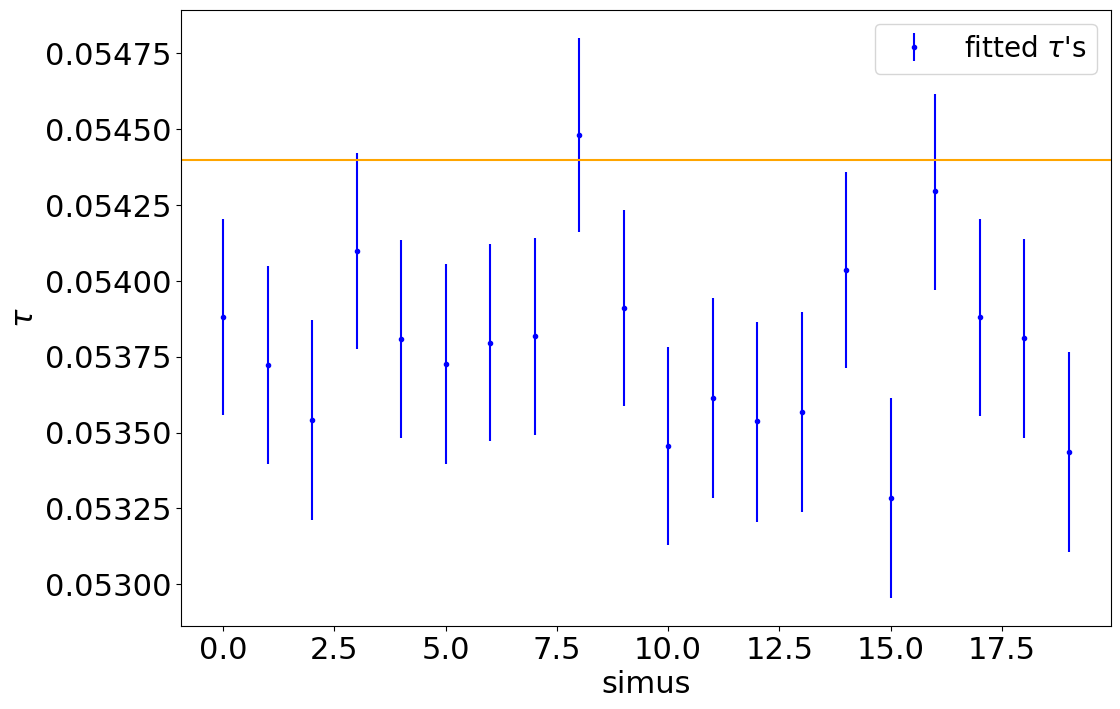

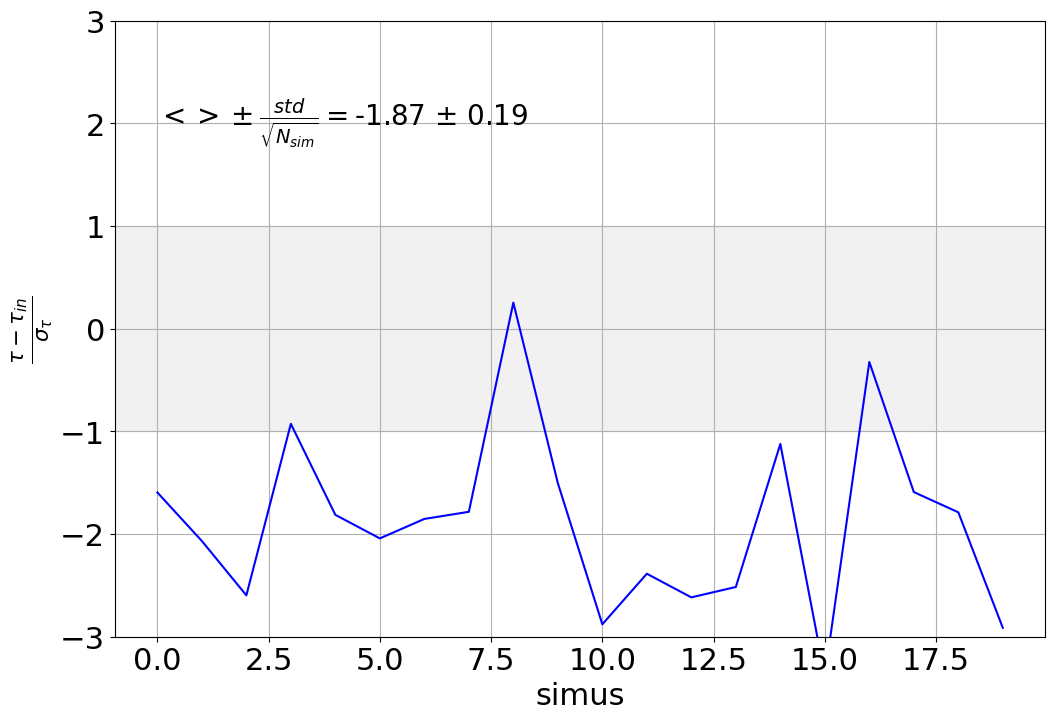

In [8]:
plt.figure()
for i in range(len(cls[:nsp])): plt.errorbar(i, opt_list[i], [[low_list[i]], [up_list[i]]], fmt = '.', color = 'blue')
plt.errorbar([], [], [[]], fmt = '.', color = 'blue', label = r"fitted $\tau$'s")
plt.axhline(tau_input, color='orange')
plt.legend(fontsize=20) 
define_plot_resolution()
plt.ylabel(r'$\tau$')
plt.xlabel('simus')
plt.show()


plt.figure()
plt.plot(list(range(len(opt_list))), (np.array(opt_list)-tau_input)/np.array(low_list), color = 'blue')
define_plot_resolution()
plt.ylabel(r'$\frac{\tau-\tau_{in}}{\sigma_\tau}$')
plt.axhspan(-1, 1, color = 'lightgray', alpha=0.3)
plt.grid()
chi2 = np.sum((np.array(opt_list)-tau_input)**2/np.array(low_list)**2)/len(cls[:nsp])
chi = np.sum((np.array(opt_list)-tau_input)/np.array(low_list))/np.sqrt(len(cls[:nsp]))#np.sqrt(len(cls))
mean_bias = np.mean((np.array(opt_list)-tau_input)/np.array(low_list))#np.sqrt(len(cls))
err_bias = np.std((np.array(opt_list)-tau_input)/np.array(low_list))/np.sqrt(len(cls[:nsp]))

plt.text(0, 1.5, s = ''+
        r'$<>\pm \frac{std}{\sqrt{N_{sim}}}=$'+f'{round(mean_bias, 2)}'+r' $\pm$ '+ f'{round(err_bias,2)}'+'\n' +
        '',
         fontsize = 20)
plt.ylim(-3, 3)

plt.xlabel('simus')
plt.show()
